# Exploratory Data Analysis - Data.Rio Data Lake

#### Import modules and libraries

In [12]:
import matplotlib.pyplot as plt, seaborn as sns; sns.set() # data visualization modules

#### Data class to host datasets and system's paths

In [13]:
import os, pandas as pd
from IPython.display import clear_output as co

class data:
    
    def __init__(self, path=None, load=True, exts=['.csv', '.xlsx'], include=None):
        self.path = path
        self.exts = exts
        self.files = os.listdir(self.path)
        self.dfs, self.failed = {}, {}
        if load:
            self.load(reload=True, include=include)

            
    def load(self, path=None, reload=False, include=None):
        
        if path is not None:
            self.path = path
            self.files = os.listdir(self.path)
        
        if reload:
            self.dfs, self.failed = {}, {}
        
        cur_dfs = list(self.dfs.keys())

        for i, file in enumerate(self.files):
            name = file.split('.')[0]
            co(wait=True); print(f'{i+1}/{len(self.files)} - {name}')
            if name in cur_dfs:
                continue
            if include is not None:
                if name not in include:
                    continue                    
            for ext in self.exts:                    
                if file.endswith(ext):
                    try: self.dfs[name] = pd.read_csv(self.path+file)
                    except Exception: self.failed[name] = {'error': Exception}

### Load Data Folders

In [14]:
Data = data(path='../../../Dados/Desafio COR-Rio IV/Meio Ambiente Clima/', load=True)

5/5 - Sub_Bacias_Hidrograficas


In [15]:
Data.load('Dados/', include=['incident_catalog'])

4/4 - incident_catalog


In [16]:
Data.dfs.keys()

dict_keys(['Estações_Meteorológicas_INMET', 'Estações_Pluviométricas_AlertaRio', 'Hidrografia', 'Meteorologia_INMET', 'Sub_Bacias_Hidrograficas', 'incident_catalog'])

### Load datasets

In [17]:
catalog = Data.dfs['incident_catalog']
inmet = Data.dfs['Meteorologia_INMET']

---
# Data Cleaning

#### Extract modeling target data

In [87]:
catalog = catalog[catalog['POP_TITULO']=="Bolsão d'água em via"]

#### Datetime data type conversion

In [19]:
catalog['evento_inicio'] = pd.to_datetime(catalog['evento_inicio'])
inmet['datetime'] = pd.to_datetime(inmet['data'] + ' ' + inmet['horario'])

inmet.set_index(['datetime'], inplace=True)

---
# Exploratory Data Analysis

In [20]:
catalog_keys = ['EVENTO_ID', 'route', 'lat', 'lng', 'evento_inicio', 'evento_fim']
inmet_leys = ['primary_keys', 'id_estacao', 'datetime']

##### Record count per day per station

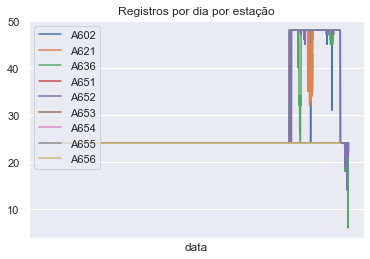

In [21]:
ax = inmet.groupby(['data', 'id_estacao']).count()['primary_key'].unstack().plot(xticks=[], title='Registros por dia por estação')
ax.legend(loc='upper left')
plt.show()

Conclusion: Stations have fixed 24 records per day. Some periods show 48 records per day indicating duplicates

#### Total observations per station

In [23]:
inmet['id_estacao'].value_counts()#.plot.bar()

A602    126914
A652    126630
A621    126451
A636    126446
A655    105912
A656    105912
A654    105912
A653    105912
A651    105912
Name: id_estacao, dtype: int64

---
# Merging datasets

#### Options:

1. stack all stations' variables as columns, inside defined frenquecy
2. New columns for first, second, third, etc, closest stations variables.

#### Stacking stations observtions

In [27]:
def stack_groups(df, group_col, drop_cols=[]):
    groups = df[group_col].unique()
    stacked = []
    for group in groups:
        group_df = df[df[group_col]==group].drop(drop_cols, 1)
        group_df = group_df.rename(columns={col: col+' - '+group for col in group_df.columns})
        stacked.append(group_df)
        if group==groups[0]:
            stacked = group_df; continue
        stacked = pd.merge(stacked, group_df, on=group_df.index.name)
#     return pd.concat(stacked, 1, join='inner')
    return stacked

In [28]:
stacked = stack_groups(
    inmet, group_col='id_estacao',
    drop_cols=['primary_key', 'id_estacao', 'data', 'horario', 'data_particao']
)

In [ ]:
stacked.shape

In [43]:
stacked

,pressao - A602,pressao_minima - A602,pressao_maxima - A602,temperatura_orvalho - A602,temperatura_orvalho_minimo - A602,temperatura_orvalho_maximo - A602,umidade - A602,umidade_minima - A602,umidade_maxima - A602,temperatura - A602,...,umidade_minima - A656,umidade_maxima - A656,temperatura - A656,temperatura_minima - A656,temperatura_maxima - A656,rajada_vento_max - A656,direcao_vento - A656,velocidade_vento - A656,radiacao_global - A656,acumulado_chuva_1_h - A656
datetime,,,,,,,,,,,,,,,,,,,,,
2012-04-01 21:00:00,1014.5,1014.5,1014.7,NaN,NaN,NaN,NaN,NaN,NaN,24.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-01 17:00:00,1014.5,1014.5,1015.0,NaN,NaN,NaN,NaN,NaN,NaN,25.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-01 16:00:00,1015.0,1014.9,1015.7,NaN,NaN,NaN,NaN,NaN,NaN,25.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-01 23:00:00,1015.5,1014.9,1015.5,NaN,NaN,NaN,NaN,NaN,NaN,23.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-01 08:00:00,1014.9,1014.6,1014.9,NaN,NaN,NaN,NaN,NaN,NaN,20.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-07-09 18:00:00,1023.6,1023.6,1024.2,17.9,17.3,18.1,NaN,NaN,NaN,22.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-24 18:00:00,1023.6,1023.6,1024.1,15.8,14.7,16.2,NaN,NaN,NaN,24.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-24 20:00:00,1023.6,1023.4,1023.6,16.7,15.2,16.7,NaN,NaN,NaN,22.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [235]:
inmet

,primary_key,id_estacao,data,horario,pressao,pressao_minima,pressao_maxima,temperatura_orvalho,temperatura_orvalho_minimo,temperatura_orvalho_maximo,...,temperatura,temperatura_minima,temperatura_maxima,rajada_vento_max,direcao_vento,velocidade_vento,radiacao_global,acumulado_chuva_1_h,data_particao,month
datetime,,,,,,,,,,,,,,,,,,,,,
2012-04-01 21:00:00,A602-2012-04-01 21:00:00,A602,2012-04-01,21:00:00,1014.5,1014.5,1014.7,NaN,NaN,NaN,...,24.3,24.2,24.7,5.0,NaN,4.0,74.565,0.0,2012-04-01,2012-04
2012-04-01 17:00:00,A602-2012-04-01 17:00:00,A602,2012-04-01,17:00:00,1014.5,1014.5,1015.0,NaN,NaN,NaN,...,25.9,25.2,26.6,5.1,NaN,4.1,2817.476,0.0,2012-04-01,2012-04
2012-04-01 16:00:00,A602-2012-04-01 16:00:00,A602,2012-04-01,16:00:00,1015.0,1014.9,1015.7,NaN,NaN,NaN,...,25.9,24.6,26.3,4.7,NaN,3.8,2913.985,0.0,2012-04-01,2012-04
2012-04-01 23:00:00,A602-2012-04-01 23:00:00,A602,2012-04-01,23:00:00,1015.5,1014.9,1015.5,NaN,NaN,NaN,...,23.2,23.0,23.5,4.0,NaN,1.3,-3.540,0.0,2012-04-01,2012-04
2012-04-01 08:00:00,A602-2012-04-01 08:00:00,A602,2012-04-01,08:00:00,1014.9,1014.6,1014.9,NaN,NaN,NaN,...,20.4,20.1,20.6,2.8,NaN,1.4,-2.620,0.0,2012-04-01,2012-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-07-05 23:00:00,A656-2017-07-05 23:00:00,A656,2017-07-05,23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-07-05,2017-07
2017-07-03 23:00:00,A656-2017-07-03 23:00:00,A656,2017-07-03,23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-07-03,2017-07
2017-07-12 23:00:00,A656-2017-07-12 23:00:00,A656,2017-07-12,23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-07-12,2017-07


---
### Model Arquitectures:

1. New variables would be day of the month, of the year, weekday, month, week of the year.

1. Each observation as a row with every station variable as columns for each time of defined frequency + column for cluster and flag of incident
2. Same as before but separete for each cluster
3. Attempt to unify the experience of every cluster by creating universal variables such:
    1. Variables of first, second and third closest stations
    2. Distance of closest stations